# GROUP ASSIGNMENT 2
# RSM 8413

In [ ]:
!pip install dmba

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

from dmba import classificationSummary
from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical

In [ ]:
# Read data from excel file into a dataframe

xlsx =pd.ExcelFile('/content/ebayAuctions.xlsx')
df= pd.read_excel(xlsx, 'eBay auctions')

# DATA PREPROCESSING AND EXPLORATION

In [ ]:
df.info()
df1 = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [ ]:
# Remove space from column names

df.columns = df.columns.str.replace(' ', '')

In [ ]:
df.head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [ ]:
df = df.rename(columns={'Competitive?': 'Competitive'})


In [ ]:
df.isnull().sum()

Category        0
Currency        0
sellerRating    0
Duration        0
endDay          0
ClosePrice      0
OpenPrice       0
Competitive     0
dtype: int64

In [ ]:
df['Category'].unique()

array(['Music/Movie/Game', 'Automotive', 'SportingGoods', 'Home/Garden',
       'Books', 'Collectibles', 'Business/Industrial', 'Toys/Hobbies',
       'Electronics', 'Computer', 'EverythingElse',
       'Clothing/Accessories', 'Coins/Stamps', 'Antique/Art/Craft',
       'Jewelry', 'Pottery/Glass', 'Health/Beauty', 'Photography'],
      dtype=object)

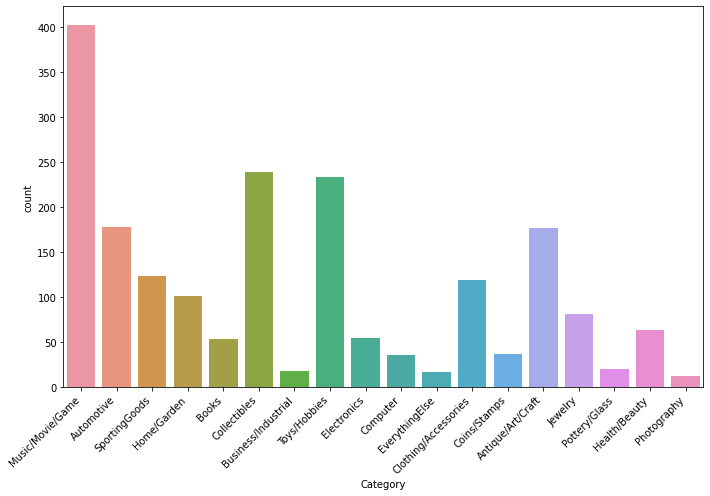

In [ ]:
plt.figure(figsize=(10,7)) 
ax = sns.countplot(data = df, x = 'Category')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
sns.color_palette("husl", 8)
plt.show()

In [ ]:
df['Currency'].unique()

array(['US', 'GBP', 'EUR'], dtype=object)

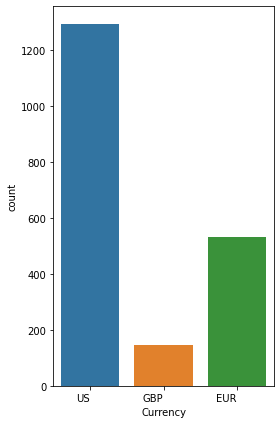

In [ ]:
plt.figure(figsize=(4,6)) 
ax = sns.countplot(data = df, x = 'Currency')
ax.set_xticklabels(ax.get_xticklabels(), rotation= 0, ha="right")
plt.tight_layout()
sns.color_palette("husl", 8)
plt.show()

In [ ]:
df['endDay'].unique()

array(['Mon', 'Tue', 'Fri', 'Thu', 'Sat', 'Sun', 'Wed'], dtype=object)

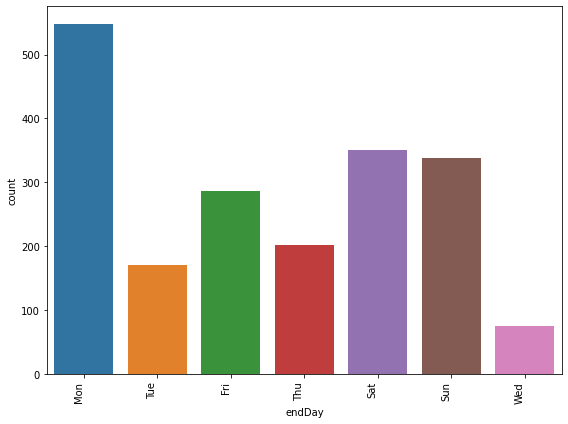

In [ ]:
plt.figure(figsize=(8,6)) 
ax = sns.countplot(data = df, x = 'endDay')
ax.set_xticklabels(ax.get_xticklabels(), rotation= 90, ha="right")
plt.tight_layout()
sns.color_palette("husl", 8)
plt.show()

In [ ]:
df['Duration'].unique()

array([ 5,  7,  1,  3, 10])

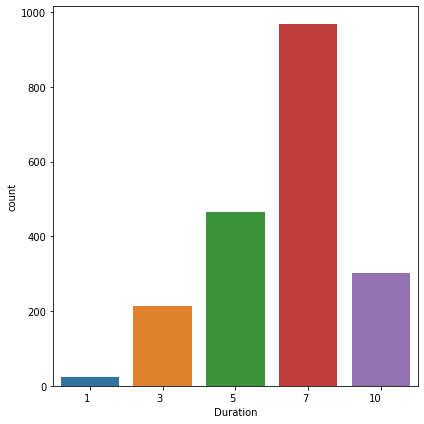

In [ ]:
plt.figure(figsize=(6,6)) 
ax = sns.countplot(data = df, x = 'Duration')
ax.set_xticklabels(ax.get_xticklabels(), rotation= 0, ha="right")
plt.tight_layout()
sns.color_palette("husl", 8)
plt.show()

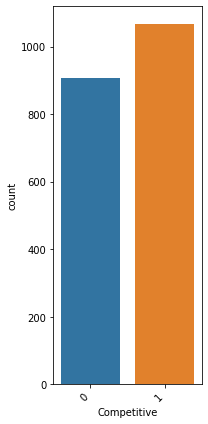

In [ ]:
plt.figure(figsize=(3,6)) 
ax = sns.countplot(data = df, x = 'Competitive')
ax.set_xticklabels(ax.get_xticklabels(), rotation= 45, ha="right")
plt.tight_layout()
sns.color_palette("husl", 8)
plt.show()

In [ ]:
# Ensure the validity of data
ambigious_data = df[(df['Competitive'] == 1) & (df['ClosePrice'] == df['OpenPrice'])]
ambigious_data.count()
ambigious_data.shape


(38, 8)

In [90]:
 # Remove rows with ambigious data 
df = df.drop(df[(df['Competitive'] == 1) & (df['ClosePrice'] == df['OpenPrice'])].index)

In [ ]:
#Creating dummy variables for the categorical predictors.
column_list =['Category', 'Currency', 'endDay', 'Duration']
def hot_encode(df, var):
    h_enc = pd.get_dummies(df[var],prefix = var+'_')
    h_enc = h_enc.iloc[: , :-1]
    df_temp = df.drop(var,axis=1)
    df1 = pd.concat([df_temp,h_enc],axis=1)
    return df1

df3 = df.copy()
for i in column_list:
    df3 = hot_encode(df3,i)

In [ ]:
# Final encoded data
df = df3.copy()
df

,sellerRating,ClosePrice,OpenPrice,Competitive,Category__Antique/Art/Craft,Category__Automotive,Category__Books,Category__Business/Industrial,Category__Clothing/Accessories,Category__Coins/Stamps,Category__Collectibles,Category__Computer,Category__Electronics,Category__EverythingElse,Category__Health/Beauty,Category__Home/Garden,Category__Jewelry,Category__Music/Movie/Game,Category__Photography,Category__Pottery/Glass,Category__SportingGoods,Currency__EUR,Currency__GBP,endDay__Fri,endDay__Mon,endDay__Sat,endDay__Sun,endDay__Thu,endDay__Tue,Duration__1,Duration__3,Duration__5,Duration__7
0,3249,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,3249,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,3249,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,3249,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,3249,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,2992,359.95,359.95,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1968,21,610.00,300.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1969,1400,549.00,549.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1970,57,820.00,650.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


# Classification

In [ ]:
#Split the data into training and validation datasets using a 60%:40% ratio

X = df.drop(columns = ['Competitive'])
y = df['Competitive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=1)

Initial Tree

In [ ]:
param_grid = {
    'min_samples_leaf': [50],
    'max_depth': [5,10,13,25,27],
    'min_samples_split' :list(range(10,120)),
    'min_impurity_decrease' : [0,0.0009, 0.001, 0.0011]
}

# Cross Validation DT
gridSearch = GridSearchCV(DecisionTreeClassifier(criterion='gini', random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Best Score: ', gridSearch.best_score_)
print('Best Parameters: ', gridSearch.best_params_)

# Summary: Best Estimator

print("\n'Best Estimator: '")
initialClassTree = gridSearch.best_estimator_
print("\n'Training Data'\n -------------------------")
classificationSummary(y_train, initialClassTree.predict(X_train))
print("\n'Testing Data'\n -------------------------")
classificationSummary(y_test, initialClassTree.predict(X_test))

Best Score:  0.8396551724137931
Best Parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_leaf': 50, 'min_samples_split': 10}

'Best Estimator: '

'Training Data'
 -------------------------
Confusion Matrix (Accuracy 0.8603)

       Prediction
Actual   0   1
     0 499  56
     1 106 499

'Testing Data'
 -------------------------
Confusion Matrix (Accuracy 0.8682)

       Prediction
Actual   0   1
     0 323  28
     1  74 349


In [ ]:
#copy dot file contects to graphviz to generate the graph
export_graphviz(initialClassTree, out_file = 'initialClassTree.dot', feature_names= X_train.columns)

In [ ]:
from sklearn.tree import export_text
r = export_text(initialClassTree, feature_names= list(X_train.columns))
print(r)

|--- OpenPrice <= 1.77
|   |--- ClosePrice <= 1.81
|   |   |--- class: 0
|   |--- ClosePrice >  1.81
|   |   |--- class: 1
|--- OpenPrice >  1.77
|   |--- ClosePrice <= 10.03
|   |   |--- OpenPrice <= 4.92
|   |   |   |--- ClosePrice <= 4.03
|   |   |   |   |--- OpenPrice <= 2.67
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- OpenPrice >  2.67
|   |   |   |   |   |--- class: 0
|   |   |   |--- ClosePrice >  4.03
|   |   |   |   |--- class: 1
|   |   |--- OpenPrice >  4.92
|   |   |   |--- ClosePrice <= 6.52
|   |   |   |   |--- class: 0
|   |   |   |--- ClosePrice >  6.52
|   |   |   |   |--- OpenPrice <= 7.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- OpenPrice >  7.99
|   |   |   |   |   |--- class: 0
|   |--- ClosePrice >  10.03
|   |   |--- OpenPrice <= 10.97
|   |   |   |--- Currency__EUR <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Currency__EUR >  0.50
|   |   |   |   |--- class: 1
|   |   |--- OpenPrice >  10.97
|   |   |   |--- sellerRating <= 535

Tuned Tree

In [ ]:
param_grid = {
    'min_samples_leaf': [50],
    'max_depth' : list(range(2,16)),
    'min_samples_split' :list(range(10,120)),
    'min_impurity_decrease' : [0,0.0009, 0.001, 0.0011]
}

# Cross Validation DT
gridSearch = GridSearchCV(DecisionTreeClassifier(criterion='gini', random_state=1), param_grid, cv=7, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Best Score: ', gridSearch.best_score_)
print('Best Parameters: ', gridSearch.best_params_)

# Summary: Best Estimator

print("\n'Best Estimator: '")
initialClassTree_tuned = gridSearch.best_estimator_
print("\n'Training Data'\n -------------------------")
classificationSummary(y_train, initialClassTree_tuned.predict(X_train))
print("\n'Testing Data'\n -------------------------")
classificationSummary(y_test, initialClassTree_tuned.predict(X_test))



Best Score:  0.8499921764982006
Best Parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_leaf': 50, 'min_samples_split': 10}

'Best Estimator: '

'Training Data'
 -------------------------
Confusion Matrix (Accuracy 0.8603)

       Prediction
Actual   0   1
     0 499  56
     1 106 499

'Testing Data'
 -------------------------
Confusion Matrix (Accuracy 0.8682)

       Prediction
Actual   0   1
     0 323  28
     1  74 349


In [ ]:
#copy dot file contects to graphviz to generate the graph
export_graphviz(initialClassTree_tuned, out_file = 'initialClassTree_tuned.dot', feature_names= X_train.columns)

Weighted Tree

In [ ]:
#lets set the weights in such a  way that the small class has a weight so the that its balanced a minority class =1.5,
# larger class =.5

sample_weight =compute_sample_weight (class_weight ='balanced',y=y_train)

In [ ]:
#be careful about where the class weight go in

In [ ]:
param_grid = {
    'min_samples_leaf': [50],
    'max_depth' : list(range(2,16)),
    'min_samples_split' :list(range(10,120)),
    'min_impurity_decrease' : [0,0.0009, 0.001, 0.0011]
}

#be careful about where the class weight go in

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state =1), param_grid, cv=5, n_jobs =-1)
gridSearch.fit(X_train,y_train, sample_weight)
print('Re-weighted Score: ', gridSearch.best_score_)
print('Re-weighted Parameters: ', gridSearch.best_params_)

print("\n'Best Estimator: '")
bestClassTree = gridSearch.best_estimator_
print("\n'Training Data'\n -------------------------")
classificationSummary(y_train, bestClassTree.predict(X_train))
print("\n'Testing Data'\n -------------------------")
classificationSummary(y_test, bestClassTree.predict(X_test))

Re-weighted Score:  0.8396551724137931
Re-weighted Parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_leaf': 50, 'min_samples_split': 10}

'Best Estimator: '

'Training Data'
 -------------------------
Confusion Matrix (Accuracy 0.8603)

       Prediction
Actual   0   1
     0 499  56
     1 106 499

'Testing Data'
 -------------------------
Confusion Matrix (Accuracy 0.8682)

       Prediction
Actual   0   1
     0 323  28
     1  74 349


### Tree with reduced no of variables

Tree with 'ClosePrice' removed

In [ ]:
reduc_df = df1.copy()
reduc_df  = reduc_df .drop(columns = ['ClosePrice'])
column_list = ['Category', 'Currency', 'endDay','Duration']
reduc_df 


for col in column_list:
    reduc_df  = pd.concat([reduc_df.drop(col, axis=1), pd.get_dummies(reduc_df[col], prefix = '_')], axis=1)
reduc_df 

#Split the data into training and validation datasets using a 60%:40% ratio
#Data does not have close price

X = reduc_df.drop(columns = ['Competitive?',])
y = reduc_df['Competitive?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=1)



param_grid = {
    'min_samples_leaf': [50],
    'max_depth' : list(range(2,16)),
    'min_samples_split' :list(range(10,120)),
    'min_impurity_decrease' : [0,0.0009, 0.001, 0.0011]
}



# Cross Validation DT
gridSearch = GridSearchCV(DecisionTreeClassifier(criterion='gini', random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Best Score: ', gridSearch.best_score_)
print('Best Parameters: ', gridSearch.best_params_)

# Summary: Best Estimator

print("\n'Best Estimator: '")
bestClassTree = gridSearch.best_estimator_
print("\n'Training Data'\n -------------------------")
classificationSummary(y_train, bestClassTree.predict(X_train))
print("\n'Testing Data'\n -------------------------")
classificationSummary(y_test, bestClassTree.predict(X_test))

Best Score:  0.7033183150969033
Best Parameters:  {'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_leaf': 50, 'min_samples_split': 115}

'Best Estimator: '

'Training Data'
 -------------------------
Confusion Matrix (Accuracy 0.7219)

       Prediction
Actual   0   1
     0 402 151
     1 178 452

'Testing Data'
 -------------------------
Confusion Matrix (Accuracy 0.7250)

       Prediction
Actual   0   1
     0 261  92
     1 125 311


Weighted Tree - Reduced Tree Model ('ClosePrice')

In [ ]:

sample_weight =compute_sample_weight (class_weight ='balanced',y=y_train)

param_grid = {
    'min_samples_leaf': [50],
    'max_depth' : list(range(2,16)),
    'min_samples_split' :list(range(10,120)),
    'min_impurity_decrease' : [0,0.0009, 0.001, 0.0011]
}

#be careful about where the class weight go in

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state =1), param_grid, cv=5, n_jobs =-1)
gridSearch.fit(X_train,y_train, sample_weight)
print('Re-weighted Score: ', gridSearch.best_score_)
print('Re-weighted Parameters: ', gridSearch.best_params_)

print("\n'Best Estimator: '")
bestClassTree = gridSearch.best_estimator_
print("\n'Training Data'\n -------------------------")
classificationSummary(y_train, bestClassTree.predict(X_train))
print("\n'Testing Data'\n -------------------------")
classificationSummary(y_test, bestClassTree.predict(X_test))

Re-weighted Score:  0.7033183150969033
Re-weighted Parameters:  {'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_leaf': 50, 'min_samples_split': 115}

'Best Estimator: '

'Training Data'
 -------------------------
Confusion Matrix (Accuracy 0.7219)

       Prediction
Actual   0   1
     0 402 151
     1 178 452

'Testing Data'
 -------------------------
Confusion Matrix (Accuracy 0.7250)

       Prediction
Actual   0   1
     0 261  92
     1 125 311


Tree with 'ClosePrice' and 'Currency' Removed

In [ ]:
reduc_df2 = df1.copy()
reduc_df2  = reduc_df2 .drop(columns =  ['ClosePrice','Currency'])
column_list = ['Category', 'endDay','Duration']

for col in column_list:
  reduc_df2  = pd.concat([reduc_df2.drop(col, axis=1), pd.get_dummies(reduc_df2[col], prefix = '_')], axis=1)
reduc_df2

,sellerRating,OpenPrice,Competitive?,__Antique/Art/Craft,__Automotive,__Books,__Business/Industrial,__Clothing/Accessories,__Coins/Stamps,__Collectibles,__Computer,__Electronics,__EverythingElse,__Health/Beauty,__Home/Garden,__Jewelry,__Music/Movie/Game,__Photography,__Pottery/Glass,__SportingGoods,__Toys/Hobbies,__Fri,__Mon,__Sat,__Sun,__Thu,__Tue,__Wed,__1,__3,__5,__7,__10
0,3249,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,3249,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,3249,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,3249,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,3249,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,2992,359.95,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1968,21,300.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1969,1400,549.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1970,57,650.00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#Split the data into training and validation datasets using a 60%:40% ratio
#Data does not have close price
y = reduc_df2['Competitive?']
X = reduc_df2.drop(columns = ['Competitive?',])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=1)


param_grid = {
    'min_samples_leaf': [50],
    'max_depth' : list(range(2,16)),
    'min_samples_split' :list(range(10,120)),
    'min_impurity_decrease' : [0,0.0009, 0.001, 0.0011]
}

#Split the data into training and validation datasets using a 60%:40% ratio
#Data does not have close price



In [ ]:
# Cross Validation DT

sample_weight =compute_sample_weight (class_weight ='balanced',y=y_train)


gridSearch = GridSearchCV(DecisionTreeClassifier(criterion='gini', random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train,y_train, sample_weight)
print('Best Score: ', gridSearch.best_score_)
print('Best Parameters: ', gridSearch.best_params_)

# Summary: Best Estimator

print("\n'Best Estimator: '")
final_reduced_ClassTree = gridSearch.best_estimator_
print("\n'Training Data'\n -------------------------")
classificationSummary(y_train, final_reduced_ClassTree.predict(X_train))
print("\n'Testing Data'\n -------------------------")
classificationSummary(y_test, final_reduced_ClassTree.predict(X_test))

Best Score:  0.7050060788099836
Best Parameters:  {'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_leaf': 50, 'min_samples_split': 115}

'Best Estimator: '

'Training Data'
 -------------------------
Confusion Matrix (Accuracy 0.7219)

       Prediction
Actual   0   1
     0 402 151
     1 178 452

'Testing Data'
 -------------------------
Confusion Matrix (Accuracy 0.7250)

       Prediction
Actual   0   1
     0 261  92
     1 125 311


In [ ]:
#copy dot file contects to graphviz to generate the graph
export_graphviz(final_reduced_ClassTree, out_file = 'final_reduced_ClassTree.dot', feature_names= X_train.columns)
r = export_text(final_reduced_ClassTree, feature_names= list(X_train.columns))
print(r)

|--- OpenPrice <= 3.62
|   |--- OpenPrice <= 1.04
|   |   |--- sellerRating <= 3138.50
|   |   |   |--- class: 1
|   |   |--- sellerRating >  3138.50
|   |   |   |--- class: 1
|   |--- OpenPrice >  1.04
|   |   |--- sellerRating <= 2365.50
|   |   |   |--- class: 1
|   |   |--- sellerRating >  2365.50
|   |   |   |--- class: 0
|--- OpenPrice >  3.62
|   |--- sellerRating <= 601.50
|   |   |--- sellerRating <= 128.00
|   |   |   |--- class: 1
|   |   |--- sellerRating >  128.00
|   |   |   |--- class: 1
|   |--- sellerRating >  601.50
|   |   |--- __Toys/Hobbies <= 0.50
|   |   |   |--- class: 0
|   |   |--- __Toys/Hobbies >  0.50
|   |   |   |--- class: 0



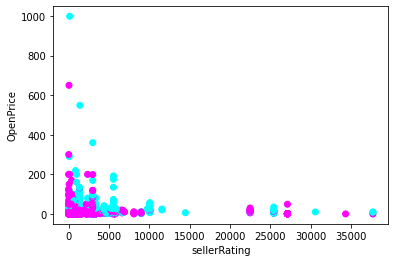

In [ ]:
%matplotlib inline

# the only two quantitative predictors are seller rating and open price
plt.scatter(df['sellerRating'],df['OpenPrice'], 
            c = df['Competitive'], cmap = 'cool')
plt.xlabel('sellerRating')
plt.ylabel('OpenPrice')
plt.show()

[]

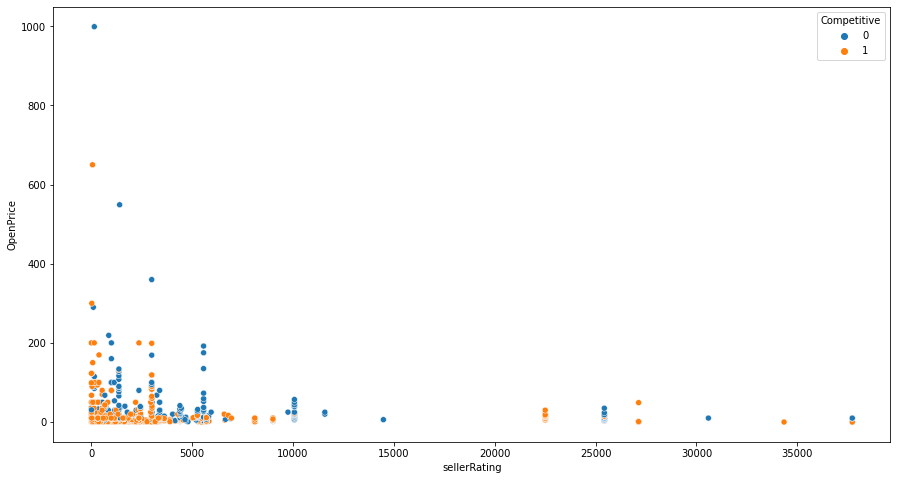

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=df, x= df['sellerRating'], y= df['OpenPrice'], hue= df['Competitive'])
ax.plot()

[]

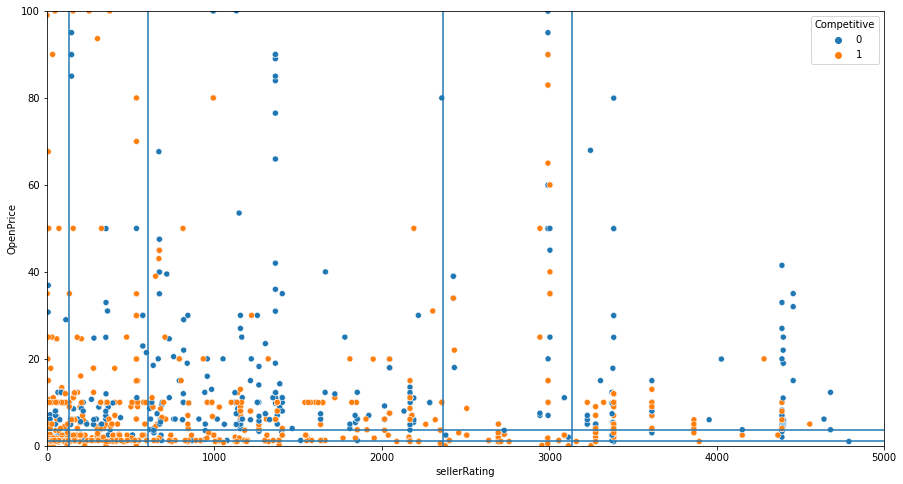

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=df, x= df['sellerRating'], y= df['OpenPrice'], hue= df['Competitive'])

plt.axhline(y=3.615)
plt.axhline(y=1.035)

plt.axvline(x=601.5)
plt.axvline(x=128)
plt.axvline(x=2365.5)
plt.axvline(x=3138.5)

plt.ylim(0, 100)
plt.xlim(0, 5000)

ax.plot()

[]

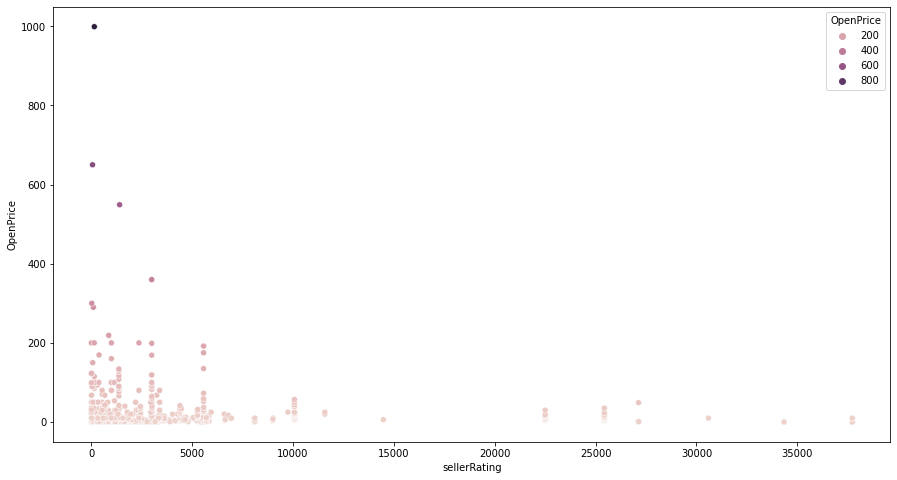

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=df, x= df['sellerRating'], y= df['OpenPrice'], hue= df['OpenPrice'])
ax.plot()